<a href="https://colab.research.google.com/github/jgtiu/Made-With-ML/blob/dev/Copy_of_madewithml_ipynb_(open_with_Chrome).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
    <h3>ML for Developers</h3>
    Design · Develop · Deploy · Iterate
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-40K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/MadeWithML"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/GokuMohandas/MadeWithML" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

This notebooks contains the code for the 🔢&nbsp; Data and 📈&nbsp; Modeling lessons. After this proof of concept (PoC), we'll be moving all of this code to Python scripts to serve our application to production. Follow the accompanying [lessons](https://madewithml.com/) along with the code here to develop a deeper understanding of all the concepts.

<div align="left">
<a target="_blank" href="https://madewithml.com/"><img src="https://img.shields.io/badge/📖 Read-lessons-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/Made-With-ML/blob/main/notebooks/madewithml.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

<font color='red'>Keep an eye out for notes entitled **ATTN**. These indicate code or notes I added to allow this notebook to work on Colab. </font>

# 🛠️ Setup

We'll be using [Ray](https://ray.io) to develop our application using distributed workloads.

In [1]:
# ATTN: I added this to ensure we use Python 3.10
# See https://madewithml.com/courses/mlops/setup/#environment
!python3 --version

Python 3.10.12


In [2]:
!pip list | grep setuptools  # ATTN: I added this to ensure this is <= 69.5.1

setuptools                       67.7.2
types-setuptools                 70.0.0.20240523


In [3]:
# ATTN: madewithml imports
!python3 -m pip install -r https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/requirements.txt

In [4]:
import os
import ray

In [5]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [6]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-05-27 01:32:27,496	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.12', ray_version='2.7.0', ray_commit='b4bba4717f5ba04ee25580fe8f88eed63ef0c5dc', protocol_version=None)

In [7]:
# ATTN: We need this to view the dashboard. For this to work, use Chrome.
from google.colab import output
output.serve_kernel_port_as_window(8265)

<IPython.core.display.Javascript object>

In [8]:
ray.cluster_resources()

{'CPU': 2.0,
 'memory': 7882560308.0,
 'node:172.28.0.12': 1.0,
 'GPU': 1.0,
 'accelerator_type:None': 1.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 3941280153.0}

These cluster resources only reflect our head node ([m5.2xlarge](https://instances.vantage.sh/aws/ec2/m5.2xlarge)). But recall in our [setup lesson](https://madewithml.com/courses/mlops/setup/) that our [compute configuration](https://madewithml.com/courses/mlops/setup/#compute) that we also added [g4dn.xlarge](https://instances.vantage.sh/aws/ec2/g4dn.xlarge) worker nodes (each has 1 GPU and 4 CPU) to our cluster. But because we set `min_workers=0`, our worker nodes will autoscale ( up to `max_workers`) as they're needed for specific workloads (ex. training).

In [9]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 1, "GPU": 1}

If you are running this on a local laptop (no GPU), use the CPU count from `ray.cluster_resources()` to set your resources. For example if your machine has 10 CPUs:

```python
num_workers = 6  # prefer to do a few less than total available CPU (1 for head node + 1 for background tasks)
resources_per_worker={"CPU": 1, "GPU": 0}
```

In [10]:
# ATTN
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [11]:
# Storage
EFS_DIR = f"/gdrive/My Drive/efs/shared_storage/madewithml/"  # ATTN
print (EFS_DIR)

/gdrive/My Drive/efs/shared_storage/madewithml/


# Data

## 🔢 Data ingestion

In [12]:
import pandas as pd

In [13]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

id           created_on                                              title   
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...  \
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  25  2020-03-07 23:04:31                                      AttentionWalk   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...            other  
3  A curated list of Monte Carlo tree search pape...            other  
4  A PyTorch Implementation of "Watch Your Step: ...            other

## ✂️ Data splitting

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [16]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [17]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [18]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 🔍 Exploratory Data Analysis (EDA)

Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc.) depending on how well the problem is defined.

In [19]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [20]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

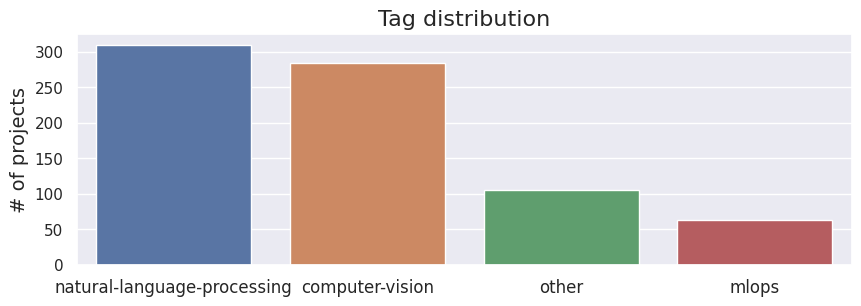

In [21]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

> We'll address the [data imbalance](https://madewithml.com/courses/mlops/baselines#data-imbalance) after splitting into our train split and prior to training our model.

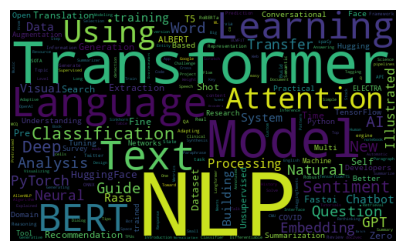

In [22]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like the `title` text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the `description` text feature as well. This information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we [split](https://madewithml.com/courses/mlops/splitting) the data first before preprocessing to avoid data leaks.

In [23]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

### Feature engineering

We can combine existing input features to create new meaningful signal (helping the model learn).

In [24]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text

In [25]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [27]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Clean DataFrame

In [28]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

text              tag
0  comparison yolo rcnn real world videos bringin...  computer-vision
1  show infer tell contextual inference creative ...  computer-vision
2  awesome graph classification collection import...            other
3  awesome monte carlo tree search curated list m...            other
4  attentionwalk pytorch implementation watch ste...            other

### Label encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [29]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [30]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

text  tag
0  comparison yolo rcnn real world videos bringin...    2
1  show infer tell contextual inference creative ...    2
2  awesome graph classification collection import...    3
3  awesome monte carlo tree search curated list m...    3
4  attentionwalk pytorch implementation watch ste...    3

In [31]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [32]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a [tokenizer](https://huggingface.co/allenai/scibert_scivocab_uncased/blob/main/vocab.txt) that was used for a pretrained LLM ([scibert](https://huggingface.co/allenai/scibert_scivocab_uncased)) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [33]:
import numpy as np
from transformers import BertTokenizer

In [34]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [35]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [36]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

<hr>

We'll combine all of our preprocessing steps into function:

In [37]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [38]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

### Distributed preprocessing

The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [39]:
# ATTN
!git clone -l -s https://github.com/GokuMohandas/Made-With-ML.git Made-With-ML
%cd Made-With-ML
!ls

Cloning into 'Made-With-ML'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 212 (delta 42), reused 76 (delta 29), pack-reused 102
Receiving objects: 100% (212/212), 4.51 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/Made-With-ML
datasets  docs	   madewithml  mkdocs.yml  pyproject.toml  requirements.txt
deploy	  LICENSE  Makefile    notebooks   README.md	   tests


In [40]:
from madewithml.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [41]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2024-05-27 01:33:24,160	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-05-27 01:33:24,179	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-05-27 01:33:24,188	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:33:24,192	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:24,197	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 1151,
  'created_on': datetime.datetime(2020, 6, 3, 7, 25, 27),
  'title': 'Web Mining and Information theory',
  'description': 'Mining the Web and playing with Natural Language processing. Implementing Information retrieval System tasks. Going towards the NLP and Performing Machine Learning algorithms. Through these codes and problems, I have understood the information retrieval process of any search engine. These are very useful problems towards sentiment analysis.',
  'tag': 'natural-language-processing'}]

In [42]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-05-27 01:33:26,087	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:33:26,090	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:26,091	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-05-27 01:33:26,918	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:33:26,921	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:26,923	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-27 01:33:28,753	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-05-27 01:33:28,756	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:28,758	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-05-27 01:33:30,305	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-05-27 01:33:30,307	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:30,310	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=9431) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=9431)   warnings.warn(


{'ids': array([  102,  6317, 21024, 30121, 11257, 15567,  6317, 21024, 30121,
        6317, 13749,  1904,   551,   791, 11257, 15567,   103,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Training

When developing models, it's always a best practice to start with the simplest models and slowly motivate more complex models. For example our baseline model progression would be:

1. random model (predict labels randomly)
2. rule-based model (pattern match labels in input text)
3. logistic regression (td-idf vectors from text)
4. CNN (apply character filters over text)
5. Fine-tune LLM (this notebook)

We cover all of these methods in our [other lessons](https://madewithml.com/#foundations) but since our focus here in on MLOps, we will skip directly to fine-tuning an LLM for our task.

We'll first set up some functions that will help us achieve complete reproducibility.

In [45]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [46]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [47]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [48]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self

    def transform(self, ds):
        return ds.map_batches(
            preprocess,
            fn_kwargs={"class_to_index": self.class_to_index},
            batch_format="pandas")

## 🤖 Model

In [49]:
import torch.nn as nn
from transformers import BertModel

In [50]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [52]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [53]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## 📦 Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (`padding="longest"`). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom `collate_fn` to repad the items in our training batches.

In [54]:
from ray.train.torch import get_device

Created a temporary directory at /tmp/tmpo6dga7f2
Writing /tmp/tmpo6dga7f2/_remote_module_non_scriptable.py


In [55]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [56]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

> `pad=(0, max_len)` in [F.pad](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch-nn-functional-pad) refers to (left_padding, right_padding) on the input. There will be no left-padding (hence the `0`) and only right-padding. And the `constant` mode refers to each element being padded to a constant size (size of longest element in the input).

In [57]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-05-27 01:33:42,268	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-05-27 01:33:42,271	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:42,274	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=9431) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=9431)   warnings.warn(


{'ids': tensor([[  102,  6317, 21024,  ...,     0,     0,     0],
         [  102,  2762,   784,  ...,     0,     0,     0],
         [  102, 10850,   142,  ...,     0,     0,     0],
         ...,
         [  102,  5363, 14440,  ...,     0,     0,     0],
         [  102,  3942,  8837,  ...,     0,     0,     0],
         [  102,   504,  3657,  ...,     0,     0,     0]], device='cuda:0',
        dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 3, 0, 2,
         2, 0, 2, 2, 1, 3, 0, 0, 0, 3, 1, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2,
         0, 3, 3, 2, 0, 3, 2, 3, 2, 3, 0, 0, 3, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 3,
         3, 0, 0, 2, 0, 3, 0, 2, 2, 0, 0, 0, 3, 3, 2, 

## 🧮 Utilities

In [58]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [59]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [60]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [61]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

Our dataset doesn't suffer from horrible class imbalance, but if it did, we could easily account for it through our loss function. There are also other strategies such as [over-sampling](https://imbalanced-learn.org/stable/over_sampling.html) less frequent classes and [under-sampling](https://imbalanced-learn.org/stable/under_sampling.html) popular classes.

```python
# Class weights
batch_counts = []
for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
counts = [sum(count) for count in zip(*batch_counts)]
class_weights = np.array([1.0/count for i, count in enumerate(counts)])
class_weights_tensor = torch.Tensor(class_weights).to(get_device())

# Training components
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
...
```

## 🗂️ Configurations

In [62]:
from madewithml.config import EFS_DIR

In [63]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [64]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

In [65]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path=EFS_DIR)

## 🚂 Training

In [66]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-05-27 01:33:47,680	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-05-27 01:33:47,692	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:33:47,697	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:47,701	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [67]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor =  preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-05-27 01:33:48,303	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:33:48,305	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:48,308	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-27 01:33:49,646	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-05-27 01:33:49,648	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:33:49,650	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-27 01:38:52,343	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-05-27 01:38:52,345	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:38:52,348	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=9431) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=9431)   warnings.warn(
2024-05-27 01:38:54,227	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-05-27 01:38:54,230	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:38:54,232	INFO streaming

- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [68]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

In [69]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [70]:
%%time
# Train
results = trainer.fit()

2024-05-27 01:38:56,637	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949



View detailed results here: /efs/shared_storage/madewithml/llm
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/llm`

Training started with configuration:
+----------------------------------------+
| Training config                        |
+----------------------------------------+
| train_loop_config/batch_size       256 |
| train_loop_config/dropout_p        0.5 |
| train_loop_config/lr            0.0001 |
| train_loop_config/lr_factor        0.8 |
| train_loop_config/lr_patience        3 |
| train_loop_config/num_classes        4 |
| train_loop_config/num_epochs        10 |
+----------------------------------------+


(TorchTrainer pid=11473) Starting distributed worker processes: ['11530 (172.28.0.12)']
(RayTrainWorker pid=11530) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=11530) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(RayTrainWorker pid=11530)   warnings.warn(
(SplitCoordinator pid=11569) Auto configuring locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3']
(RayTrainWorker pid=11530) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.

(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000000)
2024-05-27 01:39:23,422	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training finished iteration 1 at 2024-05-27 01:39:23. Total running time: 26s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000000 |
| time_this_iter_s               20.58856 |
| time_total_s                   20.58856 |
| training_iteration                    1 |
| epoch                                 0 |
| lr                               0.0001 |
| train_loss                      0.58295 |
| val_loss                        0.50079 |
+-----------------------------------------+
Training saved a checkpoint for iteration 1 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000000


(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11569) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000001)
2024-05-27 01:39:30,633	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training finished iteration 2 at 2024-05-27 01:39:30. Total running time: 33s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000001 |
| time_this_iter_s                7.02266 |
| time_total_s                   27.61121 |
| training_iteration                    2 |
| epoch                                 1 |
| lr                               0.0001 |
| train_loss                      0.48731 |
| val_loss                        0.41808 |
+-----------------------------------------+
Training saved a checkpoint for iteration 2 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000001


(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11569) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000002)
2024-05-27 01:39:37,361	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training finished iteration 3 at 2024-05-27 01:39:37. Total running time: 40s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000002 |
| time_this_iter_s                6.59474 |
| time_total_s                   34.20595 |
| training_iteration                    3 |
| epoch                                 2 |
| lr                               0.0001 |
| train_loss                      0.38265 |
| val_loss                        0.30217 |
+-----------------------------------------+
Training saved a checkpoint for iteration 3 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000002


(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11569) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 4 at 2024-05-27 01:39:44. Total running time: 47s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000003 |
| time_this_iter_s                6.92071 |
| time_total_s                   41.12666 |
| training_iteration                    4 |
| epoch                                 3 |
| lr                               0.0001 |
| train_loss                      0.27762 |
| val_loss                        0.23085 |
+-----------------------------------------+
Training saved a checkpoint for iteration 4 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000003


(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000003)
2024-05-27 01:39:44,502	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_mem

(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-27 01:39:52,972	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training finished iteration 5 at 2024-05-27 01:39:52. Total running time: 56s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000004 |
| time_this_iter_s                8.45777 |
| time_total_s                   49.58443 |
| training_iteration                    5 |
| epoch                                 4 |
| lr                               0.0001 |
| train_loss                      0.20686 |
| val_loss                        0.24223 |
+-----------------------------------------+
Training saved a checkpoint for iteration 5 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000004


(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000004)
(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11569) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 6 at 2024-05-27 01:39:59. Total running time: 1min 2s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000005 |
| time_this_iter_s                6.69089 |
| time_total_s                   56.27532 |
| training_iteration                    6 |
| epoch                                 5 |
| lr                               0.0001 |
| train_loss                      0.15842 |
| val_loss                        0.17112 |
+-----------------------------------------+
Training saved a checkpoint for iteration 6 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000005


(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000005)
2024-05-27 01:39:59,909	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_mem

(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000006)
2024-05-27 01:40:09,277	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training finished iteration 7 at 2024-05-27 01:40:09. Total running time: 1min 12s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000006 |
| time_this_iter_s                9.22383 |
| time_total_s                   65.49915 |
| training_iteration                    7 |
| epoch                                 6 |
| lr                               0.0001 |
| train_loss                       0.1024 |
| val_loss                        0.16716 |
+-----------------------------------------+
Training saved a checkpoint for iteration 7 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000006


(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11569) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000007)
2024-05-27 01:40:22,378	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training finished iteration 8 at 2024-05-27 01:40:22. Total running time: 1min 25s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000007 |
| time_this_iter_s               12.95879 |
| time_total_s                   78.45794 |
| training_iteration                    8 |
| epoch                                 7 |
| lr                               0.0001 |
| train_loss                      0.07709 |
| val_loss                        0.14045 |
+-----------------------------------------+
Training saved a checkpoint for iteration 8 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000007


(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11569) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000008)
2024-05-27 01:40:29,311	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training finished iteration 9 at 2024-05-27 01:40:29. Total running time: 1min 32s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000008 |
| time_this_iter_s                6.78858 |
| time_total_s                   85.24651 |
| training_iteration                    9 |
| epoch                                 8 |
| lr                               0.0001 |
| train_loss                      0.05135 |
| val_loss                        0.12764 |
+-----------------------------------------+
Training saved a checkpoint for iteration 9 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000008


(SplitCoordinator pid=11569) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=11569) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=11569) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=11569) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=11530) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000009)
2024-05-27 01:40:38,855	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training finished iteration 10 at 2024-05-27 01:40:38. Total running time: 1min 41s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000009 |
| time_this_iter_s                9.40185 |
| time_total_s                   94.64836 |
| training_iteration                   10 |
| epoch                                 9 |
| lr                               0.0001 |
| train_loss                      0.04157 |
| val_loss                        0.12184 |
+-----------------------------------------+
Training saved a checkpoint for iteration 10 at: (local)/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000009


2024-05-27 01:40:40,134	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.



Training completed after 10 iterations at 2024-05-27 01:40:40. Total running time: 1min 43s

CPU times: user 1.92 s, sys: 1.31 s, total: 3.23 s
Wall time: 1min 43s


In [71]:
# Metrics per epoch
results.metrics_dataframe

epoch      lr  train_loss  val_loss   timestamp  should_checkpoint   done   
0      0  0.0001    0.582948  0.500788  1716773963               True  False  \
1      1  0.0001    0.487312  0.418077  1716773970               True  False   
2      2  0.0001    0.382646  0.302171  1716773977               True  False   
3      3  0.0001    0.277619  0.230848  1716773984               True  False   
4      4  0.0001    0.206864  0.242226  1716773992               True  False   
5      5  0.0001    0.158421  0.171120  1716773999               True  False   
6      6  0.0001    0.102402  0.167162  1716774009               True  False   
7      7  0.0001    0.077092  0.140452  1716774022               True  False   
8      8  0.0001    0.051349  0.127639  1716774029               True  False   
9      9  0.0001    0.041565  0.121837  1716774038               True  False   

   training_iteration     trial_id                 date  ...   
0                   1  e20bb_00000  2024-05-27_01-39-23  ...  \
1                   2  e20bb_00000  2024-05-27_01-39-30  ...   
2                   3  e20bb_00000  2024-05-27_01-39-37  ...   
3                   4  e20bb_00000  2024-05-27_01-39-44  ...   
4                   5  e20bb_00000  2024-05-27_01-39-52  ...   
5                   6  e20bb_00000  2024-05-27_01-39-59  ...   
6                   7  e20bb_00000  2024-05-27_01-40-09  ...   
7                   8  e20bb_00000  2024-05-27_01-40-22  ...   
8                   9  e20bb_00000  2024-05-27_01-40-29  ...   
9                  10  e20bb_00000  2024-05-27_01-40-38  ...   

   time_since_restore  iterations_since_restore  checkpoint_dir_name   
0           20.588557                         1    checkpoint_000000  \
1           27.611214                         2    checkpoint_000001   
2           34.205952                         3    checkpoint_000002   
3           41.126659                         4    checkpoint_000003   
4           49.584426                         5    checkpoint_000004   
5           56.275317                         6    checkpoint_000005   
6           65.499149                         7    checkpoint_000006   
7           78.457938                         8    checkpoint_000007   
8           85.246515                         9    checkpoint_000008   
9           94.648362                        10    checkpoint_000009   

  config/train_loop_config/dropout_p config/train_loop_config/lr   
0                                0.5                      0.0001  \
1                                0.5                      0.0001   
2                                0.5                      0.0001   
3                                0.5                      0.0001   
4                                0.5                      0.0001   
5                                0.5                      0.0001   
6                                0.5                      0.0001   
7                                0.5                      0.0001   
8                                0.5                      0.0001   
9                                0.5                      0.0001   

   config/train_loop_config/lr_factor  config/train_loop_config/lr_patience   
0                                 0.8                                     3  \
1                                 0.8                                     3   
2                                 0.8                                     3   
3                                 0.8                                     3   
4                                 0.8                                     3   
5                                 0.8                                     3   
6                                 0.8                                     3   
7                                 0.8                                     3   
8                                 0.8                                     3   
9                                 0.8                                     3   

  con

In [72]:
# Best checkpoints
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/llm/TorchTrainer_e20bb_00000_0_2024-05-27_01-38-56/checkpoint_000009),
  {'epoch': 9,
   'lr': 0.0001,
   'train_loss': 0.04156502584616343,
   'val_loss': 0.12183729559183121,
   'timestamp': 1716774038,
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 10,
   'trial_id': 'e20bb_00000',
   'date': '2024-05-27_01-40-38',
   'time_this_iter_s': 9.401846885681152,
   'time_total_s': 94.64836168289185,
   'pid': 11473,
   'hostname': '0ad8cd30033c',
   'node_ip': '172.28.0.12',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 94.64836168289185,
   'iterations_since_restore': 10})]

### Evaluation

In [73]:
from sklearn.metrics import precision_recall_fscore_support

In [74]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()

    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}

    def get_preprocessor(self):
        return self.preprocessor

    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [75]:
# Artifacts
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [76]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2024-05-27 01:40:43,413	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-05-27 01:40:43,420	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-05-27 01:40:43,421	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:40:43,424	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=9431) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=9431)   warnings.warn(


[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'targets': 3}]

In [77]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2024-05-27 01:40:44,179	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-05-27 01:40:44,182	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:40:44,184	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432)   warnings.warn(


[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [78]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])

2024-05-27 01:40:44,929	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2024-05-27 01:40:44,930	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:40:44,932	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=9431) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=9431)   warnings.warn(
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=9431) <ipython-input-56-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=9432) /usr/local/lib/pyt

In [79]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9320448909921077,
 'recall': 0.9267015706806283,
 'f1': 0.9257223560973167}

In [80]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])

    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [81]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2024-05-27 01:41:13,824	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-05-27 01:41:13,828	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:41:13,833	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432)   warnings.warn(
2024-05-27 01:41:14,504	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2024-05-27 01:41:14,507	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:41:14,508	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.Da

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`. [repeated 6x across cluster]
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=9432)   warnings.warn( [repeated 6x across cluster]


{
  "precision": 0.9320448909921077,
  "recall": 0.9267015706806283,
  "f1": 0.9257223560973167
}


### Inference

In [82]:
import pandas as pd

In [83]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [84]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    results = []
    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [85]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2024-05-27 01:41:38,494	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-05-27 01:41:38,496	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:41:38,499	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=9431) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=9431)   warnings.warn(


[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00018496571,
   'mlops': 0.00027950492,
   'natural-language-processing': 0.99925226,
   'other': 0.00028322364}}]

# 🧪 Experiment tracking

So far, we've been training our models but we don't have a way to more deeply track and compare them. We'll achieve this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the processing of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

- **Organize** all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
- **Reproduce** past results (easily) using saved experiments.
- **Log** iterative improvements across time, data, ideas, teams, etc.

There are many options for experiment tracking but we're going to use [MLflow](https://mlflow.org/) (100% free and [open-source](https://github.com/mlflow/mlflow)) because it has all the functionality we'll need (and [growing integration support](https://docs.ray.io/en/latest/tune/examples/tune-mlflow.html)). There are also several popular options such as a [Comet ML](https://www.comet.ml/site/) (Used by Google AI, HuggingFace, etc.) and [Weights and Biases](https://www.wandb.com/) (Used by Open AI, Toyota Research, etc.). These are fantastic options if you want a fully managed experiment tracking solution.

In [86]:
import mlflow
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback
import time

In [87]:
# Config MLflow
MODEL_REGISTRY = Path(f"{EFS_DIR}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///efs/shared_storage/madewithml/mlflow


In [88]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [89]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR
)

In [90]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-05-27 01:41:41,587	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-05-27 01:41:41,596	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:41:41,597	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:41:41,599	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [91]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-05-27 01:41:42,105	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:41:42,107	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:41:42,110	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-27 01:41:42,973	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-05-27 01:41:42,978	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:41:42,979	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-27 01:46:45,278	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-05-27 01:46:45,293	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:46:45,296	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=9431) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=9431)   warnings.warn(
2024-05-27 01:46:47,295	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-05-27 01:46:47,298	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:46:47,300	INFO streaming

- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [92]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [93]:
%%time
# Train
results = trainer.fit()

2024-05-27 01:46:49,211	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949



View detailed results here: /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49
To visualize your results with TensorBoard, run: `tensorboard --logdir /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49`

Training started with configuration:
+----------------------------------------+
| Training config                        |
+----------------------------------------+
| train_loop_config/batch_size       256 |
| train_loop_config/dropout_p        0.5 |
| train_loop_config/lr            0.0001 |
| train_loop_config/lr_factor        0.8 |
| train_loop_config/lr_patience        3 |
| train_loop_config/num_classes        4 |
| train_loop_config/num_epochs        10 |
+----------------------------------------+


(TorchTrainer pid=13658) Starting distributed worker processes: ['13722 (172.28.0.12)']
(RayTrainWorker pid=13722) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=13722) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(RayTrainWorker pid=13722)   warnings.warn(
(SplitCoordinator pid=13765) Auto configuring locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3']
(RayTrainWorker pid=13722) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight',

(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000000)



Training finished iteration 1 at 2024-05-27 01:47:14. Total running time: 25s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000000 |
| time_this_iter_s               16.80453 |
| time_total_s                   16.80453 |
| training_iteration                    1 |
| epoch                                 0 |
| lr                               0.0001 |
| train_loss                      0.58295 |
| val_loss                        0.50079 |
+-----------------------------------------+
Training saved a checkpoint for iteration 1 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000000


(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 2 at 2024-05-27 01:47:27. Total running time: 38s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000001 |
| time_this_iter_s               13.28896 |
| time_total_s                   30.09349 |
| training_iteration                    2 |
| epoch                                 1 |
| lr                               0.0001 |
| train_loss                      0.48731 |
| val_loss                        0.41808 |
+-----------------------------------------+
Training saved a checkpoint for iteration 2 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000001


(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000001)
(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 3 at 2024-05-27 01:47:58. Total running time: 1min 9s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000002 |
| time_this_iter_s               30.29675 |
| time_total_s                   60.39024 |
| training_iteration                    3 |
| epoch                                 2 |
| lr                               0.0001 |
| train_loss                      0.38265 |
| val_loss                        0.30217 |
+-----------------------------------------+
Training saved a checkpoint for iteration 3 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000002


(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000002)
(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 4 at 2024-05-27 01:48:22. Total running time: 1min 32s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000003 |
| time_this_iter_s               23.70507 |
| time_total_s                   84.09531 |
| training_iteration                    4 |
| epoch                                 3 |
| lr                               0.0001 |
| train_loss                      0.27762 |
| val_loss                        0.23085 |
+-----------------------------------------+
Training saved a checkpoint for iteration 4 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000003


(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000003)
(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 5 at 2024-05-27 01:48:55. Total running time: 2min 6s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000004 |
| time_this_iter_s               33.56078 |
| time_total_s                   117.6561 |
| training_iteration                    5 |
| epoch                                 4 |
| lr                               0.0001 |
| train_loss                      0.20686 |
| val_loss                        0.24223 |
+-----------------------------------------+


(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000004)
2024-05-27 01:48:57,901	WARNING util.py:315 -- The `callbacks.on_trial_result` operation took 2.266 s, which may be a performance bottleneck.
2024-05-27 01:48:57,913	WARNING util.py:315 -- The `process_trial_result` operation took 2.279 s, which may be a performance bottleneck.
2024-05-27 01:48:57,929	WARNING util.py:315 -- Processing trial results took 2.294 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-27 01:48:57,935	WARNING util.py:315 -- The `process_trial_result` operation took 2.295 s, which may be a performance bottleneck.
(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions

(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

Training saved a checkpoint for iteration 5 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000004

Training finished iteration 6 at 2024-05-27 01:49:28. Total running time: 2min 39s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000005 |
| time_this_iter_s               30.41284 |
| time_total_s                  148.06894 |
| training_iteration                    6 |
| epoch                                 5 |
| lr                               0.0001 |
| train_loss                      0.15842 |
| val_loss                        0.17112 |
+-----------------------------------------+
Training saved a checkpoint for iteration 6 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000005


(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000005)
(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000006)



Training finished iteration 7 at 2024-05-27 01:49:58. Total running time: 3min 9s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000006 |
| time_this_iter_s               30.03331 |
| time_total_s                  178.10225 |
| training_iteration                    7 |
| epoch                                 6 |
| lr                               0.0001 |
| train_loss                       0.1024 |
| val_loss                        0.16716 |
+-----------------------------------------+
Training saved a checkpoint for iteration 7 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000006


(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 8 at 2024-05-27 01:50:28. Total running time: 3min 39s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000007 |
| time_this_iter_s               29.55055 |
| time_total_s                   207.6528 |
| training_iteration                    8 |
| epoch                                 7 |
| lr                               0.0001 |
| train_loss                      0.07709 |
| val_loss                        0.14045 |
+-----------------------------------------+
Training saved a checkpoint for iteration 8 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000007


(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000007)
(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000008)



Training finished iteration 9 at 2024-05-27 01:50:58. Total running time: 4min 8s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000008 |
| time_this_iter_s               29.61969 |
| time_total_s                  237.27249 |
| training_iteration                    9 |
| epoch                                 8 |
| lr                               0.0001 |
| train_loss                      0.05135 |
| val_loss                        0.12764 |
+-----------------------------------------+
Training saved a checkpoint for iteration 9 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000008


(SplitCoordinator pid=13765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=13765) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]


Training finished iteration 10 at 2024-05-27 01:51:34. Total running time: 4min 44s
+-----------------------------------------+
| Training result                         |
+-----------------------------------------+
| checkpoint_dir_name   checkpoint_000009 |
| time_this_iter_s               35.83448 |
| time_total_s                  273.10698 |
| training_iteration                   10 |
| epoch                                 9 |
| lr                               0.0001 |
| train_loss                      0.04157 |
| val_loss                        0.12184 |
+-----------------------------------------+
Training saved a checkpoint for iteration 10 at: (local)/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000009


(RayTrainWorker pid=13722) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000009)


copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/result.json -> /efs/shared_storage/madewithml/mlflow/503757461910460690/f3a46843c5f14ea8a12002de31262a14/artifacts
creating /efs/shared_storage/madewithml/mlflow/503757461910460690/f3a46843c5f14ea8a12002de31262a14/artifacts/checkpoint_000009
copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000009/args.json -> /efs/shared_storage/madewithml/mlflow/503757461910460690/f3a46843c5f14ea8a12002de31262a14/artifacts/checkpoint_000009
copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0_2024-05-27_01-46-49/checkpoint_000009/.metadata.json -> /efs/shared_storage/madewithml/mlflow/503757461910460690/f3a46843c5f14ea8a12002de31262a14/artifacts/checkpoint_000009
copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-46-49/TorchTrainer_fbb7c_00000_0

In [94]:
results.metrics_dataframe

epoch      lr  train_loss  val_loss   timestamp  should_checkpoint   done   
0      0  0.0001    0.582948  0.500788  1716774434               True  False  \
1      1  0.0001    0.487312  0.418077  1716774447               True  False   
2      2  0.0001    0.382646  0.302171  1716774478               True  False   
3      3  0.0001    0.277619  0.230848  1716774502               True  False   
4      4  0.0001    0.206864  0.242226  1716774535               True  False   
5      5  0.0001    0.158421  0.171120  1716774568               True  False   
6      6  0.0001    0.102402  0.167162  1716774598               True  False   
7      7  0.0001    0.077092  0.140452  1716774628               True  False   
8      8  0.0001    0.051349  0.127639  1716774658               True  False   
9      9  0.0001    0.041565  0.121837  1716774694               True  False   

   training_iteration     trial_id                 date  ...   
0                   1  fbb7c_00000  2024-05-27_01-47-14  ...  \
1                   2  fbb7c_00000  2024-05-27_01-47-27  ...   
2                   3  fbb7c_00000  2024-05-27_01-47-58  ...   
3                   4  fbb7c_00000  2024-05-27_01-48-22  ...   
4                   5  fbb7c_00000  2024-05-27_01-48-55  ...   
5                   6  fbb7c_00000  2024-05-27_01-49-28  ...   
6                   7  fbb7c_00000  2024-05-27_01-49-58  ...   
7                   8  fbb7c_00000  2024-05-27_01-50-28  ...   
8                   9  fbb7c_00000  2024-05-27_01-50-58  ...   
9                  10  fbb7c_00000  2024-05-27_01-51-34  ...   

   time_since_restore  iterations_since_restore  checkpoint_dir_name   
0           16.804526                         1    checkpoint_000000  \
1           30.093489                         2    checkpoint_000001   
2           60.390242                         3    checkpoint_000002   
3           84.095313                         4    checkpoint_000003   
4          117.656098                         5    checkpoint_000004   
5          148.068938                         6    checkpoint_000005   
6          178.102247                         7    checkpoint_000006   
7          207.652800                         8    checkpoint_000007   
8          237.272493                         9    checkpoint_000008   
9          273.106978                        10    checkpoint_000009   

  config/train_loop_config/dropout_p config/train_loop_config/lr   
0                                0.5                      0.0001  \
1                                0.5                      0.0001   
2                                0.5                      0.0001   
3                                0.5                      0.0001   
4                                0.5                      0.0001   
5                                0.5                      0.0001   
6                                0.5                      0.0001   
7                                0.5                      0.0001   
8                                0.5                      0.0001   
9                                0.5                      0.0001   

   config/train_loop_config/lr_factor  config/train_loop_config/lr_patience   
0                                 0.8                                     3  \
1                                 0.8                                     3   
2                                 0.8                                     3   
3                                 0.8                                     3   
4                                 0.8                                     3   
5                                 0.8                                     3   
6                                 0.8                                     3   
7                                 0.8                                     3   
8                                 0.8                                     3   
9                                 0.8                                     3   

  con

In [95]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

run_id       experiment_id    status   
0  f3a46843c5f14ea8a12002de31262a14  503757461910460690  FINISHED  \

                                        artifact_uri   
0  file:///efs/shared_storage/madewithml/mlflow/5...  \

                        start_time                         end_time   
0 2024-05-27 01:46:57.676000+00:00 2024-05-27 01:51:44.213000+00:00  \

   metrics.time_this_iter_s  metrics.config/train_loop_config/lr_patience   
0                 35.834485                                           3.0  \

   metrics.time_since_restore  metrics.train_loss  ...   
0                  273.106978            0.041565  ...  \

   metrics.config/train_loop_config/dropout_p   
0                                         0.5  \

   params.train_loop_config/num_epochs  params.train_loop_config/num_classes   
0                                   10                                     4  \

   params.train_loop_config/batch_size  params.train_loop_config/lr   
0                                  256                       0.0001  \

   params.train_loop_config/lr_patience  params.train_loop_config/dropout_p   
0                                     3                                 0.5  \

   params.train_loop_config/lr_factor           tags.trial_name   
0                                 0.8  TorchTrainer_fbb7c_00000  \

        tags.mlflow.runName  
0  TorchTrainer_fbb7c_00000  

[1 rows x 35 columns]

In [96]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

run_id                                                           f3a46843c5f14ea8a12002de31262a14
experiment_id                                                                  503757461910460690
status                                                                                   FINISHED
artifact_uri                                    file:///efs/shared_storage/madewithml/mlflow/5...
start_time                                                       2024-05-27 01:46:57.676000+00:00
end_time                                                         2024-05-27 01:51:44.213000+00:00
metrics.time_this_iter_s                                                                35.834485
metrics.config/train_loop_config/lr_patience                                                  3.0
metrics.time_since_restore                                                             273.106978
metrics.train_loss                                                                       0.041565
metrics.epoch       

### Dashboard

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:

```bash
mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri $EFS_DIR/mlflow
```

<font color='red'>ATTN: I haven't found a way to display the MLflow dashboard yet </font>

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/dashboard.png" width="1000" alt="mlflow runs">

And within each run, we can view metrics, parameters, artifacts, etc.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/params.png" width="1000" alt="mlflow params">

And we can even create custom plots to help us visualize our results.

<img src="https://madewithml.com/static/images/mlops/experiment_tracking/plots.png" width="1000" alt="mlflow plots">

### Loading

In [97]:
from ray.train import Result
from urllib.parse import urlparse

In [98]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [99]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [100]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2024-05-27 01:51:48,770	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-05-27 01:51:48,775	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:51:48,778	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432)   warnings.warn(
(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432)   warnings.warn(
(MapBatches(preprocess)->MapBatches(<lambda>) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in ver

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=9432)   warnings.warn(
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=15099) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=15099)   warnings.warn(
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=15099) <ipython-input-56-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non

{
  "precision": 0.9320448909921077,
  "recall": 0.9267015706806283,
  "f1": 0.9257223560973167
}


In [101]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2024-05-27 01:52:21,232	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-05-27 01:52:21,233	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:52:21,235	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=15099) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=15099)   warnings.warn(


[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00018496571,
   'mlops': 0.00027950492,
   'natural-language-processing': 0.99925226,
   'other': 0.00028322364}}]

# ⚙ Hyperparameter tuning

In [102]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [103]:
# Number of trials (small sample)
num_runs = 2

In [104]:
# Set up
set_seeds()

In [105]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-05-27 01:52:24,092	INFO read_api.py:406 -- To satisfy the requested parallelism of 4, each read task output is split into 4 smaller blocks.
2024-05-27 01:52:24,100	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:52:24,102	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:52:24,105	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [106]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-05-27 01:52:24,660	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-05-27 01:52:24,663	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:52:24,665	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-27 01:52:26,559	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-05-27 01:52:26,562	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:52:26,564	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-27 01:52:28,873	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-05-27 01:52:28,878	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:52:28,879	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=9432)   warnings.warn(
2024-05-27 01:52:31,294	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-05-27 01:52:31,296	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 01:52:31,298	INFO streaming

- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=9432) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`. [repeated 4x across cluster]
(MapBatches(preprocess) pid=9432)   warnings.warn( [repeated 4x across cluster]


In [107]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [108]:
# MLflow callback
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [109]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR)

In [110]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)  # trade off b/w optimization and search space

In [111]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

In [112]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

In [113]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

In [114]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

In [115]:
%%time
# Tune
results = tuner.fit()

2024-05-27 01:57:34,485	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+---------------------------------------------------------------------+
| Configuration for experiment     TorchTrainer_2024-05-27_01-57-34   |
+---------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                    |
| Scheduler                        AsyncHyperBandScheduler            |
| Number of trials                 2                                  |
+---------------------------------------------------------------------+

View detailed results here: /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34
To visualize your results with TensorBoard, run: `tensorboard --logdir /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34`

Trial status: 1 PENDING
Current time: 2024-05-27 01:57:34. Total running time: 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------------------------

(TorchTrainer pid=16645) Starting distributed worker processes: ['16691 (172.28.0.12)']
(RayTrainWorker pid=16691) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=16740) Auto configuring locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3']
(RayTrainWorker pid=16691) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(RayTrainWorker pid=16691)   warnings.warn(
(RayTrainWorker pid=16691) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictio

(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 01:58:04. Total running time: 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
+--------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience |
+--------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_aceb99ea   RUNNING                   0.5                  0.0001                      0.8                       3       |
| TorchTrainer_e4edb40f   PENDING                   0.85057              4.08222e-05                 0.878355                  2.59397 |
+--------------------------------------------------------------------------------------------------------------------------------------+


(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000000)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 01:58:34. Total running time: 1min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.5007884502410889 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_aceb

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000001)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 01:59:04. Total running time: 1min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.41807684302330017 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ac

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000002)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 02:00:04. Total running time: 2min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.3021707832813263 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ace

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000003)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 02:01:05. Total running time: 3min 30s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.23084774613380432 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ac

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000004)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 02:01:35. Total running time: 4min 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.2422255277633667 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_aceb

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000005)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 02:02:36. Total running time: 5min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.17111988365650177 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ace

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000006)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 02:03:36. Total running time: 6min 2s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.16716153919696808 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ace

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000007)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 02:04:06. Total running time: 6min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.14045165479183197 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ac

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000008)


(pid=16740) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(SplitCoordinator pid=16740) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=16740) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=16740) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-27 02:05:07. Total running time: 7min 32s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.12763947248458862 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status       ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| TorchTrainer_ac

(RayTrainWorker pid=16691) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/checkpoint_000009)


copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/progress.csv -> /efs/shared_storage/madewithml/mlflow/503757461910460690/b3b3fa28e7494e6d8842516055882ff3/artifacts
copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/params.json -> /efs/shared_storage/madewithml/mlflow/503757461910460690/b3b3fa28e7494e6d8842516055882ff3/artifacts
copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2024-05-27_01-57-34/params.pkl -> /efs/shared_storage/madewithml/mlflow/503757461910460690/b3b3fa28e7494e6d8842516055882ff3/artifacts
copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_aceb99ea_1_dropout_p=0.5000,lr=0.

(TorchTrainer pid=19008) Starting distributed worker processes: ['19086 (172.28.0.12)']
(RayTrainWorker pid=19086) Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=19086) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(RayTrainWorker pid=19086)   warnings.warn(
(SplitCoordinator pid=19131) Auto configuring locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3']
(RayTrainWorker pid=19086) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight'

(pid=19131) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

(RayTrainWorker pid=19086) <ipython-input-56-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-05-27 02:06:49. Total running time: 9min 15s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.12183729559183121 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch       lr     train_loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Torch

(RayTrainWorker pid=19086) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_e4edb40f_2_dropout_p=0.8506,lr=0.0000,lr_factor=0.8784,lr_patience=2.5940_2024-05-27_01-57-39/checkpoint_000000)
(SplitCoordinator pid=19131) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=19131) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=19131) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=19131) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2024-05-27 02:07:50. Total running time: 10min 15s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:None)
Current best trial: aceb99ea with val_loss=0.12183729559183121 and params={'train_loop_config': {'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name              status         ..._config/dropout_p     train_loop_config/lr     ..._config/lr_factor     ...onfig/lr_patience     iter     total time (s)     epoch            lr     train_loss     val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=19086) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_e4edb40f_2_dropout_p=0.8506,lr=0.0000,lr_factor=0.8784,lr_patience=2.5940_2024-05-27_01-57-39/checkpoint_000001)
(SplitCoordinator pid=19131) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=19131) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=19131) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=19131) Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_e4edb40f_2_dropout_p=0.8506,lr=0.0000,lr_factor=0.8784,lr_patience=2.5940_2024-05-27_01-57-39/events.out.tfevents.1716775593.0ad8cd30033c -> /efs/shared_storage/madewithml/mlflow/503757461910460690/7d19182cf86b412084579d60f02d044a/artifacts
copying /efs/shared_storage/madewithml/TorchTrainer_2024-05-27_01-57-34/TorchTrainer_e4edb40f_2_dropout_p=0.8506,lr=0.0000,lr_factor=0.8784,lr_patience=2.5940_2024-05-27_01-57-39/params.pkl -> /efs/shared_storage/madewithml/mlflow/503757461910460690/7d19182cf86b412084579d60f02d044a/artifacts

Trial TorchTrainer_e4edb40f completed after 2 iterations at 2024-05-27 02:09:00. Total running time: 11min 26s
+----------------------------------------------------------+
| Trial TorchTrainer_e4edb40f result                       |
+----------------------------------------------------------+
| checkpoint_dir_name                    checkpoint_000001 |
| time_this_iter_s       

In [116]:
# All trials in experiment
results.get_dataframe()

epoch        lr  train_loss  val_loss   timestamp  should_checkpoint  done   
0      9  0.000100    0.041565  0.121837  1716775549               True  True  \
1      1  0.000041    0.546220  0.495450  1716775710               True  True   

   training_iteration  trial_id                 date  ...      hostname   
0                  10  aceb99ea  2024-05-27_02-05-49  ...  0ad8cd30033c  \
1                   2  e4edb40f  2024-05-27_02-08-30  ...  0ad8cd30033c   

       node_ip  time_since_restore iterations_since_restore   
0  172.28.0.12          489.449705                       10  \
1  172.28.0.12          117.563934                        2   

  checkpoint_dir_name  config/train_loop_config/dropout_p   
0   checkpoint_000009                             0.50000  \
1   checkpoint_000001                             0.85057   

   config/train_loop_config/lr config/train_loop_config/lr_factor   
0                     0.000100                           0.800000  \
1                     0.000041                           0.878355   

   config/train_loop_config/lr_patience    logdir  
0                              3.000000  aceb99ea  
1                              2.593974  e4edb40f  

[2 rows x 23 columns]

In [117]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe

epoch      lr  train_loss  val_loss   timestamp  should_checkpoint   done   
0      0  0.0001    0.582948  0.500788  1716775095               True  False  \
1      1  0.0001    0.487312  0.418077  1716775136               True  False   
2      2  0.0001    0.382646  0.302171  1716775185               True  False   
3      3  0.0001    0.277619  0.230848  1716775235               True  False   
4      4  0.0001    0.206864  0.242226  1716775286               True  False   
5      5  0.0001    0.158421  0.171120  1716775334               True  False   
6      6  0.0001    0.102402  0.167162  1716775389               True  False   
7      7  0.0001    0.077092  0.140452  1716775434               True  False   
8      8  0.0001    0.051349  0.127639  1716775491               True  False   
9      9  0.0001    0.041565  0.121837  1716775549               True   True   

   training_iteration  trial_id                 date  ...    pid   
0                   1  aceb99ea  2024-05-27_01-58-15  ...  16645  \
1                   2  aceb99ea  2024-05-27_01-58-56  ...  16645   
2                   3  aceb99ea  2024-05-27_01-59-46  ...  16645   
3                   4  aceb99ea  2024-05-27_02-00-35  ...  16645   
4                   5  aceb99ea  2024-05-27_02-01-26  ...  16645   
5                   6  aceb99ea  2024-05-27_02-02-14  ...  16645   
6                   7  aceb99ea  2024-05-27_02-03-09  ...  16645   
7                   8  aceb99ea  2024-05-27_02-03-54  ...  16645   
8                   9  aceb99ea  2024-05-27_02-04-51  ...  16645   
9                  10  aceb99ea  2024-05-27_02-05-49  ...  16645   

       hostname      node_ip time_since_restore iterations_since_restore   
0  0ad8cd30033c  172.28.0.12          35.774669                        1  \
1  0ad8cd30033c  172.28.0.12          76.518983                        2   
2  0ad8cd30033c  172.28.0.12         126.140215                        3   
3  0ad8cd30033c  172.28.0.12         176.050135                        4   
4  0ad8cd30033c  172.28.0.12         226.921736                        5   
5  0ad8cd30033c  172.28.0.12         274.654827                        6   
6  0ad8cd30033c  172.28.0.12         329.177459                        7   
7  0ad8cd30033c  172.28.0.12         374.227715                        8   
8  0ad8cd30033c  172.28.0.12         431.226902                        9   
9  0ad8cd30033c  172.28.0.12         489.449705                       10   

   checkpoint_dir_name  config/train_loop_config/dropout_p   
0    checkpoint_000000                                 0.5  \
1    checkpoint_000001                                 0.5   
2    checkpoint_000002                                 0.5   
3    checkpoint_000003                                 0.5   
4    checkpoint_000004                                 0.5   
5    checkpoint_000005                                 0.5   
6    checkpoint_000006                                 0.5   
7    checkpoint_000007                                 0.5   
8    checkpoint_000008                                 0.5   
9    checkpoint_000009                                 0.5   

  config/train_loop_config/lr  config/train_loop_config/lr_factor   
0                      0.0001                                 0.8  \
1                      0.0001                                 0.8   
2                      0.0001                                 0.8   
3                      0.0001                                 0.8   
4                      0.0001                                 0.8   
5                      0.0001                                 0.8   
6                      0.0001                                 0.8   
7                      0.0001                                 0.8   
8                      0.0001                                 0.8   
9                      0.0001                                 0.8   

   config/train_loop_config/lr_patience  
0                                   3.0  
1        

In [118]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

{'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}

In [119]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

run_id       experiment_id    status   
0  b3b3fa28e7494e6d8842516055882ff3  503757461910460690  FINISHED  \
1  f3a46843c5f14ea8a12002de31262a14  503757461910460690  FINISHED   
2  7d19182cf86b412084579d60f02d044a  503757461910460690  FINISHED   

                                        artifact_uri   
0  file:///efs/shared_storage/madewithml/mlflow/5...  \
1  file:///efs/shared_storage/madewithml/mlflow/5...   
2  file:///efs/shared_storage/madewithml/mlflow/5...   

                        start_time                         end_time   
0 2024-05-27 01:57:39.650000+00:00 2024-05-27 02:06:19.545000+00:00  \
1 2024-05-27 01:46:57.676000+00:00 2024-05-27 01:51:44.213000+00:00   
2 2024-05-27 02:06:33.257000+00:00 2024-05-27 02:09:00.543000+00:00   

   metrics.time_this_iter_s  metrics.config/train_loop_config/lr_patience   
0                 58.222803                                      3.000000  \
1                 35.834485                                      3.000000   
2                 45.703148                                      2.593974   

   metrics.time_since_restore  metrics.train_loss  ...   
0                  489.449705            0.041565  ...  \
1                  273.106978            0.041565  ...   
2                  117.563934            0.546220  ...   

   metrics.config/train_loop_config/num_epochs  params.train_loop_config/lr   
0                                          NaN                       0.0001  \
1                                         10.0                       0.0001   
2                                          NaN       4.0822175495681284e-05   

   params.train_loop_config/lr_patience  params.train_loop_config/dropout_p   
0                                   3.0                                 0.5  \
1                                     3                                 0.5   
2                    2.5939741347618117                  0.8505703159639761   

   params.train_loop_config/lr_factor  params.train_loop_config/num_epochs   
0                                 0.8                                 None  \
1                                 0.8                                   10   
2                  0.8783551922533079                                 None   

   params.train_loop_config/num_classes  params.train_loop_config/batch_size   
0                                  None                                 None  \
1                                     4                                  256   
2                                  None                                 None   

            tags.trial_name       tags.mlflow.runName  
0     TorchTrainer_aceb99ea     TorchTrainer_aceb99ea  
1  TorchTrainer_fbb7c_00000  TorchTrainer_fbb7c_00000  
2     TorchTrainer_e4edb40f     TorchTrainer_e4edb40f  

[3 rows x 35 columns]

In [120]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [121]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2024-05-27 02:09:09,266	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-05-27 02:09:09,267	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:09:09,270	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(<lambda>) pid=15099) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(<lambda>) pid=15099)   warnings.warn(
(MapBatches(preprocess)->MapBatches(<lambda>) pid=15099) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(<lambda>) pid=15099)   warnings.warn(
(MapBatches(preprocess)->MapBatches(<lambda>) pid=15099) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed i

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=15099) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`. [repeated 2x across cluster]
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=15099)   warnings.warn( [repeated 2x across cluster]
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=19812) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=19812)   warnings.warn(
(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=19812) <ipython-input-56-d06568f052eb>:7: UserWarning: The given N

{
  "precision": 0.9320448909921077,
  "recall": 0.9267015706806283,
  "f1": 0.9257223560973167
}


In [122]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2024-05-27 02:09:42,261	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-05-27 02:09:42,262	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:09:42,266	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=19812) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=19812)   warnings.warn(


[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.00018496571,
   'mlops': 0.00027950492,
   'natural-language-processing': 0.99925226,
   'other': 0.00028322364}}]

# ⚖️ Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

- Coarse-grained metrics
- Fine-grained metrics
- Confusion matrix
- Confidence learning
- Slice metrics

In [123]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [124]:
# Artifacts
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [125]:
# y_test
preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

2024-05-27 02:09:52,468	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2024-05-27 02:09:52,473	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:09:52,474	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(<lambda>) pid=15099) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(<lambda>) pid=15099)   warnings.warn(


In [126]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

2024-05-27 02:09:54,789	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-05-27 02:09:54,792	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:09:54,796	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=19812) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=19812)   warnings.warn(
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=19812) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=19812)   warnings.warn(
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=19812) /usr/local/lib/python3.10/dist-packages/hugging

In [127]:
# y_prob
print (np.shape(y_test))
print (np.shape(y_prob))

(191,)
(191, 4)


In [128]:
# Add columns (for convenience)
test_df = test_ds.to_pandas()
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

id          created_on                         title   
0  19 2020-03-03 13:54:31           Diffusion to Vector  \
1  26 2020-03-07 23:11:58  Graph Wavelet Neural Network   
2  44 2020-03-08 00:32:58  Capsule Graph Neural Network   
3  80 2020-03-20 05:59:32  NeRF: Neural Radiance Fields   
4  84 2020-03-20 15:18:43            Mention Classifier   

                                         description   
0  Reference implementation of Diffusion2Vec (Com...  \
1  A PyTorch implementation of "Graph Wavelet Neu...   
2  A PyTorch implementation of "Capsule Graph Neu...   
3  Representing scenes as neural radiance fields ...   
4  Category prediction model\nThis repo contains ...   

                           tag   
0                        other  \
1                        other   
2                        other   
3              computer-vision   
4  natural-language-processing   

                                                text   
0  Diffusion to Vector Reference implementation o...  \
1  Graph Wavelet Neural Network A PyTorch impleme...   
2  Capsule Graph Neural Network A PyTorch impleme...   
3  NeRF: Neural Radiance Fields Representing scen...   
4  Mention Classifier Category prediction model\n...   

                    prediction  
0                        other  
1                        other  
2                        other  
3              computer-vision  
4  natural-language-processing

### Coarse-grained metrics

In [129]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9320448909921077,
    "recall": 0.9267015706806283,
    "f1": 0.9257223560973167,
    "num_samples": 191.0
}


### Fine-grained metrics

In [130]:
from collections import OrderedDict

In [131]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [132]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.9382716049382716,
  "recall": 0.9743589743589743,
  "f1": 0.9559748427672956,
  "num_samples": 78.0
}


In [133]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 0.9382716049382716,
    "recall": 0.9743589743589743,
    "f1": 0.9559748427672956,
    "num_samples": 78.0
  }
]
[
  "computer-vision",
  {
    "precision": 0.9558823529411765,
    "recall": 0.9154929577464789,
    "f1": 0.9352517985611511,
    "num_samples": 71.0
  }
]
[
  "other",
  {
    "precision": 0.8064516129032258,
    "recall": 0.9615384615384616,
    "f1": 0.8771929824561403,
    "num_samples": 26.0
  }
]
[
  "mlops",
  {
    "precision": 1.0,
    "recall": 0.6875,
    "f1": 0.8148148148148148,
    "num_samples": 16.0
  }
]


### Confusion matrix

- **True positives (TP)**: learn about where our model performs well.
- **False positives (FP)**: potentially identify samples which may need to be relabeled.
- False negatives (FN): identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [134]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [135]:
print (tp)
print (fp)
print (fn)

[4, 9, 12, 16, 17, 19, 23, 25, 26, 29, 30, 31, 32, 33, 34, 42, 47, 49, 50, 54, 56, 65, 66, 68, 71, 75, 76, 77, 78, 82, 92, 94, 95, 97, 99, 101, 109, 112, 113, 114, 118, 120, 122, 126, 128, 129, 130, 131, 133, 134, 135, 138, 139, 140, 141, 142, 144, 148, 149, 152, 159, 160, 161, 163, 166, 170, 172, 173, 174, 177, 179, 183, 184, 187, 189, 190]
[41, 83, 102, 150, 165]
[79, 115]


In [136]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")


=== True positives ===
Mention Classifier Category prediction model
This repo contains AllenNLP model for prediction of Named Entity categories by its mentions.
    true: natural-language-processing
    pred: natural-language-processing

Finetune: Scikit-learn Style Model Finetuning for NLP Finetune is a library that allows users to leverage state-of-the-art pretrained NLP models for a wide variety of downstream tasks.
    true: natural-language-processing
    pred: natural-language-processing

Finetuning Transformers with JAX + Haiku Walking through a port of the RoBERTa pre-trained model to JAX + Haiku, then fine-tuning the model to solve a downstream task.
    true: natural-language-processing
    pred: natural-language-processing


=== False positives ===
How Docker Can Help You Become A More Effective Data Scientist A look at Docker from the perspective of a data scientist.
    true: mlops
    pred: natural-language-processing

MediaPipe Simplest way for researchers and developer

### Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

**Categorical**
- prediction is incorrect (also indicate TN, FP, FN)
- confidence score for the correct class is below a threshold
- confidence score for an incorrect class is above a threshold
- standard deviation of confidence scores over top N samples is low
- different predictions from same model using different parameters

**Continuous**
- difference between predicted and ground-truth values is above some %



> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [137]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [138]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i],
            "pred": test_df.prediction[i],
            "prob": prob})

In [139]:
low_confidence[0:3]

[{'text': 'Transfer Learning in NLP with Tensorflow Hub and Keras Learn how to integrate and finetune tensorflow-hub modules in Tensorflow 2.0',
  'true': 'natural-language-processing',
  'pred': 'computer-vision',
  'prob': 0.0018124831},
 {'text': 'BERT Distillation with Catalyst How to distill BERT with Catalyst.',
  'true': 'natural-language-processing',
  'pred': 'other',
  'prob': 0.31732115}]

But these are fairly crude techniques because neural networks are easily [overconfident](https://arxiv.org/abs/1706.04599) and so their confidences cannot be used without calibrating them.

<div class="ai-center-all">
    <img src="https://madewithml.com/static/images/mlops/evaluation/calibration.png" width="300" alt="accuracy vs. confidence">
</div>
<div class="ai-center-all mt-1">
  <small>Modern (large) neural networks result in higher accuracies but are over confident.<br><a href="https://arxiv.org/abs/1706.04599" target="_blank">On Calibration of Modern Neural Networks</a></small>
</div>

* **Assumption**: *“the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”*
* **Reality**: *“modern (large) neural networks are no longer well-calibrated”*
* **Solution**: apply temperature scaling (extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling){:target="_blank"}) on model outputs

Recent work on [confident learning](https://arxiv.org/abs/1911.00068) focuses on identifying noisy labels while accounting for this overconfidence which can then be properly relabeled and used for training.

In [140]:
import cleanlab
from cleanlab.filter import find_label_issues

In [141]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

id          created_on   
165  2137 2020-08-13 02:10:03  \
103  1459 2020-06-16 03:06:10   
102  1451 2020-06-16 01:21:09   
28    414 2020-04-08 23:18:04   
79    943 2020-05-22 06:27:43   

                                                 title   
165  Unpopular Opinion - Data Scientists Should Be ...  \
103  SuperGlue: Learning Feature Matching with Grap...   
102                             EfficientDet (PyTorch)   
28                                    TensorBoard.dev    
79   Transfer Learning in NLP with Tensorflow Hub a...   

                                           description   
165  I believe data scientists can be more effectiv...  \
103  SuperGlue, a neural network that matches two s...   
102  A PyTorch implementation of EfficientDet faith...   
28   Easily host, track, and share your ML experime...   
79   Learn how to integrate and finetune tensorflow...   

                             tag                   prediction  
165                        mlops  natural-language-processing  
103                        other              computer-vision  
102              computer-vision  natural-language-processing  
28                         mlops              computer-vision  
79   natural-language-processing              computer-vision

Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predictions alongside the data. This way, we can know if we need to relabel, upsample, etc. to improve our performance. Analysis like this could also shed light on the task itself. For example, you may notice that some projects involve multiple data modalities and so it's difficult to just assing one tag. So perhaps it might be better to make this taks a multilabel classification task instead (it does but we simplified it for this course).

### Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

- Target / predicted classes (+ combinations)
- Features (explicit and implicit)
- Metadata (timestamps, sources, etc.)
- Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [142]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [143]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [144]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's [`slicing_function`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slicing_function.html) to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using [`slice_dataframe`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slice_dataframe.html).

In [145]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 14213.44it/s]


text   
12  Finetuning Transformers with JAX + Haiku Walki...  \
19  Question Answering with a Fine-Tuned BERT What...   
29  BertViz Tool for visualizing attention in the ...   
30  The Transformer Family This post presents how ...   
31  Pruning Bert to Accelerate Inference After pre...   

                            tag  
12  natural-language-processing  
19  natural-language-processing  
29  natural-language-processing  
30  natural-language-processing  
31  natural-language-processing

In [146]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 30891.61it/s]


text   
75                    NLPAug Data augmentation for NLP  \
123  Offline Reinforcement Learning Challenges, alg...   
127  Image Classifier Pure JavaScript Image Classifier   
132  imgaug Image augmentation for machine learning...   
140            QSVM Quantum SVM for sentiment analysis   

                             tag  
75   natural-language-processing  
123                        other  
127              computer-vision  
132              computer-vision  
140  natural-language-processing

We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [147]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 191/191 [00:00<00:00, 19640.88it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

To calculate metrics for our slices, we could use [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) but we've implemented a version that will work for multiclass or multilabel scenarios.

In [148]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [149]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 0.9642857142857143,
    "recall": 0.9642857142857143,
    "f1": 0.9642857142857143,
    "num_samples": 28
  },
  "short_text": {
    "precision": 0.8571428571428571,
    "recall": 0.8571428571428571,
    "f1": 0.8571428571428571,
    "num_samples": 7
  }
}


Slicing can help identify sources of *bias* in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

- enough data (new or oversampling incorrect predictions)
- masking the algorithm (using text matching heuristics).

### Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) or [LIME](https://github.com/marcotcr/lime) (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [150]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

[`LimeTextExplainer.explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance) function requires a `classifier_fn` that takes in a list of strings and outputs the predicted probabilities.

In [151]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag": "other"} for text in texts])
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [152]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1).show_in_notebook(text=True)

2024-05-27 02:10:54,889	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-05-27 02:10:55,225	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:10:55,226	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(raylet) [2024-05-27 02:11:30,978 E 9374 9374] (raylet) node_manager.cc:3007: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use 

Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=20104) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=20104)   warnings.warn(
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=20104) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=20104)   warnings.warn(
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=20104) /usr/local/lib/python3.10/dist-packages/hugging

### Behavioral testing

In [153]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2024-05-27 02:21:53,651	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-05-27 02:21:53,653	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:21:53,655	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

2024-05-27 02:22:01,131	WARNING worker.py:2058 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 3aed291bfb4faa9380843a18204f9caf1d3bf69e01000000 Worker ID: 594cf7bc87a352adeabeb479e0440fcd07d0d8787cf5f7fc74e4cf71 Node ID: 1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3 Worker IP address: 172.28.0.12 Worker port: 46453 Worker PID: 23849 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=24007) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPr

['natural-language-processing', 'natural-language-processing']

In [154]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2024-05-27 02:22:25,399	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-05-27 02:22:25,402	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:22:25,404	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

(raylet) [2024-05-27 02:22:31,052 E 9374 9374] (raylet) node_manager.cc:3007: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 1939cf241a023725db85b8da6e319c480cc7fa2dbfc9b9025f0d24e3, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=24008) /usr/local/lib/python3.10/dist-packages/hugg

['natural-language-processing', 'computer-vision']

In [155]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2024-05-27 02:22:53,109	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2024-05-27 02:22:53,111	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:22:53,114	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=24179) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=24179)   warnings.warn(
(raylet) Spilled 4196 MiB, 285 objects, write throughput 11 MiB/s.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=24179) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=24179)   warnings.warn(


['natural-language-processing', 'mlops']

We'll learn how to systematically create tests in our [testing lesson](https://madewithml.com/courses/mlops/testing#behavioral-testing). Be sure to also checkout the [evaluation lesson](https://madewithml.com/courses/mlops/evaluation) where we cover more ways to evaluate our model, including generating slices, counterfactuals and more.

# 🚀 Serving

### Batch inference (offline)

In [156]:
import ray.data
from ray.data import ActorPoolStrategy

In [157]:
# Artifacts
run_id = sorted_runs.iloc[0].run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [158]:
# Batch inference
preprocessed_ds = preprocessor.transform(test_ds)
compute = ActorPoolStrategy(min_size=1, max_size=2)
outputs = preprocessed_ds.map_batches(predictor, batch_size=128, compute=compute)
np.array([d["output"] for d in outputs.take_all()])

2024-05-27 02:23:16,235	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> ActorPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2024-05-27 02:23:16,240	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-05-27 02:23:16,243	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-05-27 02:23:18,188	INFO actor_pool_map_operator.py:106 -- MapBatches(preprocess)->MapBatches(TorchPredictor): Waiting for 1 pool actors to start...
(raylet) [2024-05-27 02:23:31,055 E 9374 9374] (raylet) node_manager.cc:3007: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other re

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapWorker(MapBatches(preprocess)->MapBatches(TorchPredictor)) pid=24423) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapWorker(MapBatches(preprocess)->MapBatches(TorchPredictor)) pid=24423)   warnings.warn(
(MapWorker(MapBatches(preprocess)->MapBatches(TorchPredictor)) pid=24423) <ipython-input-56-d06568f052eb>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(MapWorker(MapBatches(preprocess)->MapBatche

array([3, 3, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 2, 2, 3, 2, 3, 0,
       3, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 3, 2, 2, 0,
       0, 3, 1, 2, 0, 2, 2, 3, 3, 0, 2, 3, 2, 3, 3, 3, 3, 3, 0, 0, 0, 2,
       2, 3, 2, 1, 0, 2, 3, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0,
       0, 3, 0, 0, 2, 0, 2, 2, 3, 2, 0, 2, 0, 2, 2, 0, 3, 0, 0, 0, 0, 2,
       0, 0, 2, 2, 2, 3, 3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 3, 0, 2, 2, 2, 1, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1, 2, 3, 2, 2, 2, 0,
       0, 2, 0, 2, 3, 3, 0, 2, 2, 0, 1, 2, 1, 2, 2])

### Online inference (real-time)

<font color='red'>ATTN: Maybe we should take the artifact and just download it to local then try the ff code on local</font>

While we can achieve batch inference at scale, many models will need to be served in an real-time manner where we may need to deliver predictions for many incoming requests (high throughput) with low latency.

In [159]:
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request

In [160]:
# Define application
app = FastAPI(
    title="Made With ML",
    description="Classify machine learning projects.",
    version="0.1")

We'll start by defining our FastAPI application which involves initializing a predictor (and preprocessor) from the best checkpoint for a particular run (specified by `run_id`). We'll also define a `predict` function that will be used to make predictions on our input data.

In [163]:
# ATTN: I changed num_cpus from 8 to 2 because later code would give errors
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 2, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    def __init__(self, run_id):
        """Initialize the model."""
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        return {"results": results}

> `async def` refers to an asynchronous function (when we call the function we don't have to wait for the function to complete executing). The `await` keyword is used inside an asynchronous function to wait for the completion of the `request.json()` operation.

### ATTN: ATTN! Stops working at the ff cell. Also I cannot access the localhost

In [164]:
# Run service
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id), route_prefix="/")

Connecting to existing Serve app in namespace "serve". New http options will not be applied.


(ServeController pid=24709) INFO 2024-05-27 02:28:23,943 controller 24709 deployment_state.py:1390 - Deploying new version of deployment ModelDeployment in application 'default'.
(ServeController pid=24709) INFO 2024-05-27 02:28:24,127 controller 24709 deployment_state.py:1560 - Stopping 1 replicas of deployment 'ModelDeployment' in application 'default' with outdated versions.
(ServeController pid=24709) INFO 2024-05-27 02:28:24,299 controller 24709 deployment_state.py:971 - Replica default#ModelDeployment#awljaw did not shut down after grace period, force-killing it. 
(ServeController pid=24709) INFO 2024-05-27 02:28:24,511 controller 24709 deployment_state.py:2027 - Replica default#ModelDeployment#awljaw is stopped.
(ServeController pid=24709) INFO 2024-05-27 02:28:24,512 controller 24709 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeployment in application 'default'.
(ServeReplica:default:ModelDeployment pid=25845) /usr/local/lib/python3.10/dist-packages/huggingf

Deployment 'ModelDeployment:lpemfo' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ModelDeployment


2024-05-27 02:28:57,866	INFO router.py:1132 -- Using router <class 'ray.serve._private.router.PowerOfTwoChoicesReplicaScheduler'>.
2024-05-27 02:28:57,886	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeployment' in application 'default': {'default#ModelDeployment#jzSAWU'}.


RayServeSyncHandle(deployment='ModelDeployment')

In [174]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(autoscaler +1h16m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(HTTPProxyActor pid=24747) INFO 2024-05-27 02:48:38,192 http_proxy 172.28.0.12 b305784a-5c86-4b09-97ce-e34ab32c3406 / default http_proxy.py:1216 - Client for request b305784a-5c86-4b09-97ce-e34ab32c3406 disconnected during execution, cancelling request.
(HTTPProxyActor pid=24747) INFO 2024-05-27 02:49:00,730 http_proxy 172.28.0.12 59f7ee16-b426-49b0-b617-1c8fac803c3b / default http_proxy.py:1216 - Client for request 59f7ee16-b426-49b0-b617-1c8fac803c3b disconnected during execution, cancelling request.


(autoscaler +1h16m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(HTTPProxyActor pid=24747) INFO 2024-05-27 02:49:04,418 http_proxy 172.28.0.12 85df88cb-8459-47ac-bdc6-0dc49ab001ae / default http_proxy.py:1216 - Client for request 85df88cb-8459-47ac-bdc6-0dc49ab001ae disconnected during execution, cancelling request.
(HTTPProxyActor pid=24747) INFO 2024-05-27 02:49:11,587 http_proxy 172.28.0.12 32c57918-e69e-44c8-a749-0c19023b6a79 /predict/ default http_proxy.py:1216 - Client for request 32c57918-e69e-44c8-a749-0c19023b6a79 disconnected during execution, cancelling request.


KeyboardInterrupt: 

The issue with neural networks (and especially LLMs) is that they are notoriously overconfident. For every input, they will always make some prediction. And to account for this, we have an `other` class but that class only has projects that are not in our accepted tags but are still machine learning related nonetheless. Here's what happens when we input complete noise as our input:

In [ ]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Shutdown
serve.shutdown()

### Custom logic

To make our service a bit more robust, let's add some custom logic to predict the `other` class if the probability of the predicted class is below a certain `threshold` probability.

In [175]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 2, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobust:
    def __init__(self, run_id, threshold=0.9):
        """Initialize the model."""
        self.run_id = run_id
        self.threshold = threshold
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)

        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "other"

        return {"results": results}

In [176]:
# Run service
serve.run(ModelDeploymentRobust.bind(run_id=run_id, threshold=0.9), route_prefix="/")

Connecting to existing Serve app in namespace "serve". New http options will not be applied.


(ServeController pid=26893) INFO 2024-05-27 02:49:55,733 controller 26893 deployment_state.py:1390 - Deploying new version of deployment ModelDeploymentRobust in application 'default'.
2024-05-27 02:49:55,901	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeployment' in application 'default': set().
(ServeController pid=26893) INFO 2024-05-27 02:49:55,854 controller 26893 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeployment' in application 'default'.
(ServeController pid=26893) INFO 2024-05-27 02:49:55,854 controller 26893 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeploymentRobust in application 'default'.


(autoscaler +1h17m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


KeyboardInterrupt: 

In [ ]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

In [ ]:
# Shutdown
serve.shutdown()

---